In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime
import os 
import threading
import seaborn as sns; sns.set()
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import seaborn as sns
from tabulate import tabulate
import pickle
from sklearn import tree
from sklearn.metrics import r2_score


%matplotlib inline

c:\program files (x86)\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


#### Time setting

In [2]:
os.environ['TZ'] = 'UTC'   # fix timezone 
try:
    time.tzset()
except:
    pass
    
def get_time(tstamp):
    """
    Convert timestamp to str of time 
    """
    return time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(tstamp/1000))
v_get_time = np.vectorize(get_time)   # vectorize the fct 

def get_timestamp(dt):
    """
    Convert struct_time to timestamp 
    
    dt: str
    """
    return time.mktime(time.strptime(dt, "%Y-%m-%d %H:%M:%S"))
v_get_timestamp = np.vectorize(get_timestamp)

#### Maximum circular sum problem

In [3]:
### ref: https://www.geeksforgeeks.org/maximum-contiguous-circular-sum/

# Standard Kadane's algorithm to find maximum subarray sum 
def kadane(a): 
    n = len(a) 
    max_so_far = 0
    max_ending_here = 0
    ind = [0, 0]
    ind_min = 0 
    for i in range(0, n): 
        max_ending_here = max_ending_here + a[i] 
        if (max_ending_here <= 0): 
            max_ending_here = 0
            ind_min = i+1   # restart the sum from the next index 
        if (max_so_far < max_ending_here): 
            max_so_far = max_ending_here 
            ind[1] = i   # update the end index that provides the maximal sum 
            ind[0] = ind_min 
    return max_so_far, ind 

def maxCircularSum(a_): 
    a = a_.copy()
    n = len(a) 
  
    # Case 1: get the maximum sum using standard kadane's 
    # algorithm 
    max_kadane_1, ind_1 = kadane(a) 
   
    # Case 2: Now find the maximum sum that includes corner 
    # elements. 
    max_wrap = 0
    for i in range(0,n): 
        max_wrap += a[i] 
        a[i] = -a[i] 
  
    # Max sum with corner elements will be: 
    # array-sum - (-max subarray sum of inverted array) 
    max_kadane_2, ind_2 = kadane(a) 
    max_wrap = max_wrap + max_kadane_2
  
    # The maximum circular sum will be maximum of two sums 
    if max_wrap > max_kadane_1: 
        return max_wrap, [ind_2[-1]+1, ind_2[0]-1] 
    else: 
        return max_kadane_1, ind_1 
    
    
def minCircularSum(a):
    """
    Find minimum circular sum (minimum is maximum of negative)
    """
    rtn, ind = maxCircularSum(-np.array(a))
    return -rtn, ind 
    

In [4]:
a=np.array([-1, 1, 3,-1, 11,  -9])
print(maxCircularSum(a))
print(minCircularSum(a))

(14, [1, 4])
(-10, [5, 0])


#### Aggregate 1-min data to a specified interval

In [5]:
def agg_data(DF, freq = 'h'):
    df = DF.copy()
    df.index = v_get_time(df.index)
    df['Date'] = df.index.map(lambda x: x.split()[0])
    
    df['Time'] = pd.to_datetime(df.index)
    
    
    df.reset_index(drop=True, inplace=True)
    
    df_by = df[['Return', 'Date', 'Time']].groupby(['Date', pd.Grouper(key='Time', freq=freq)]).apply(np.sum).drop(['Date'], axis=1)
    
    df_by = df_by.fillna(0)
    
    df_by.index.set_levels(df_by.index.levels[1].map(lambda x: x.strftime('%Y-%m-%d %h:%m:%s')), level=1, inplace=True)
        
    return df_by

In [6]:
# a = agg_data(df_[0], freq='4h')
# a

#### Search for highest / lowest intraday return / vol

In [7]:
def agg_CircularSum(df_by):
    """
    loop over time;
    in each loop compute the extreme returns and corresponding time periods 
    """
    ts = [i[1] for i in df_by.iloc[0].index]
 
    seq = np.arange(len(ts))
    DF_max = pd.DataFrame(0, columns = df_by.index, index = ts)
    DF_min = pd.DataFrame(0, columns = df_by.index, index = ts)
    Rtn_max = pd.Series(0, index = df_by.index)
    Rtn_min = pd.Series(0, index = df_by.index)
    for y in df_by.index:
        if np.sum(df_by.loc[y].Return!=0) == 0:
            continue
            
        rtn, ind = maxCircularSum(df_by.loc[y])   # max 
        if ind[0] <= ind[1]:
            in_ = np.logical_and(seq>=ind[0], seq<=ind[1])
        elif ind[0] > ind[1]:   # this means midnight 
            in_ = np.logical_or(seq>=ind[0], seq<=ind[1])
        DF_max.loc[in_, y] = 1
        Rtn_max.loc[y] = rtn
    
        
        rtn, ind = minCircularSum(df_by.loc[y])   # min 
        if ind[0] <= ind[1]:
            in_ = np.logical_and(seq>=ind[0], seq<=ind[1])
        elif ind[0] > ind[1]:   # this means midnight 
            in_ = np.logical_or(seq>=ind[0], seq<=ind[1])
        DF_min.loc[in_, y] = 1
        Rtn_min.loc[y] = rtn
        
    return DF_max, Rtn_max, DF_min, Rtn_min

In [8]:
def agg_Max(df_by):
    """
    loop over time;
    in each loop compute the extreme returns and corresponding time periods 
    """
    ts = [i[1] for i in df_by.iloc[0].index]
 
    seq = np.arange(len(ts))
    DF_max = pd.DataFrame(0, columns = df_by.index, index = ts)
    DF_min = pd.DataFrame(0, columns = df_by.index, index = ts)
    Rtn_max = pd.Series(0, index = df_by.index)
    Rtn_min = pd.Series(0, index = df_by.index)
    for y in df_by.index:
        if np.sum(df_by.loc[y].Return!=0) == 0:
            continue
        
        temp = df_by.loc[y]
        val = temp.values
        key = temp.index.get_level_values(1)
     
        in_ = np.argmax(val)
        rtn_max = val[in_]
        DF_max.loc[key[in_], y] = 1
        Rtn_max.loc[y] = rtn_max
    
        
        in_ = np.argmin(val)
        rtn_min = val[in_]
        DF_min.loc[key[in_], y] = 1
        Rtn_min.loc[y] = rtn_min
        
    return DF_max, Rtn_max, DF_min, Rtn_min

In [9]:
def agg_NoChange(x):
    return x

In [10]:
def get_extreme_return(df, by = 'Month', f=agg_CircularSum):
    
    df_by = df.copy()
    df_by.index = df_by.index.map(' '.join)
    
    if by == 'Month':
        df_by[by] = df_by.index.map(lambda x: ''.join(x.split('-')[:2]))
    elif by == 'Day':
        df_by[by] = df_by.index.map(lambda x: x.split()[0])
    elif by == 'Year': 
        df_by[by] = df_by.index.map(lambda x: x.split('-')[0])
    
    df_by['Time'] = df_by.index.map(lambda x: x.split()[-1])   # the Hour   
    
    df_by.reset_index(drop=True, inplace=True)

    
    df_by = df_by[['Return', by, 'Time']].groupby([by, 'Time']).apply(np.mean)
    try:
        df_by = df_by.drop([by], axis=1).unstack()
    except:
        df_by = df_by.unstack()
    

    return f(df_by)

In [11]:
def get_extreme_vol(df, by = 'Month', f=agg_CircularSum):
    
    df_by = df.copy()

    df_by.index = df_by.index.map(' '.join)
    
    if by == 'Month':
        df_by[by] = df_by.index.map(lambda x: ''.join(x.split('-')[:2]))
    elif by == 'Day':
        df_by[by] = df_by.index.map(lambda x: x.split()[0])
    elif by == 'Year': 
        df_by[by] = df_by.index.map(lambda x: x.split('-')[0])
    
    df_by['Time'] = df_by.index.map(lambda x: x.split()[-1])   # the Hour   
    
    df_by.reset_index(drop=True, inplace=True)

    temp = lambda x: np.sum(x**2) / x.shape[0] 
    df_by = df_by[['Return', by, 'Time']].groupby([by, 'Time']).apply(temp)
    
    try:
        df_by = df_by.drop([by], axis=1).unstack()
    except:
        df_by = df_by.unstack()
    
    
    df_by = df_by.sub(df_by.mean(axis=1), axis=0)
    

    return f(df_by)

#### Strategy evaluation

In [12]:
def Performance(nav):
    nav=[Nav for Nav in nav if Nav!=0]
    # Annualized Return
    annualized_return = (nav[-1]/nav[0])**(252/len(nav))-1
    
    # Standard Deviation
    series_nav = pd.Series(nav)
    log_return = np.log(series_nav)-np.log(series_nav.shift(1))
    std = np.std(log_return)*np.sqrt(252)
    
    # Sharpe Ratio
    sharpe = (annualized_return-0.04)/std
    
    # Skewness
    skew = log_return.skew()
    
    # Kurtosis
    kurt = log_return.kurtosis()
    
    # VaR
    pnl = series_nav - series_nav.shift(1)
    VaR = -pnl.quantile(0.05)
    
    ## DD
    drawdown = series_nav / series_nav.cummax() - 1.0
    ## MDD
    MDD = drawdown.cummin().min()
    
    
    return annualized_return, std, sharpe, skew, kurt, VaR, drawdown, MDD

In [13]:
def show_performance(nav):
    annualized_return_s, std_s, sharpe_s, skew_s, kurt_s, VaR_s, drawdown_s, MDD_s=Performance(nav)
    returns=['Return',annualized_return_s]
    vol=['Vol',std_s]
    sharpe=['Sharpe',sharpe_s]
    skew=['Skew',skew_s]
    kurt=['Kurt',kurt_s]
    var=['VaR',VaR_s]
    dd=['MDD',MDD_s]

    table = [returns,vol,sharpe,skew,kurt,var,dd]
    print(fns_name(fns[i]))
    print(tabulate(table,headers=['Stats', 'Results'],tablefmt="github",numalign="center",floatfmt=".4f"))
    print('\n')

#### ------------------------------------------------------------
#### Empirical findings 

In [14]:
### load dataset 

path = os.path.join(os.getcwd(), 'data')   # pls put the sript together with the "data" folder  
fns = os.listdir(path)[1:]
fns_name = lambda x: ' '.join(x.split('_')[:-1])
df_ = []

length = 60*1000   # 1 min
for fn in fns:
    with open(os.path.join(path, fn), 'r') as f:
        df = pd.read_csv(f)
        df.drop_duplicates(subset=['UTC','Close'], inplace=True)
        df.set_index('UTC', inplace=True)
        df.sort_index(inplace = True)
        
        ts = np.arange(df.index.min(), df.index.max(), length)
        df = df.reindex(ts)
        df[['Open', 'High', 'Low', 'Close']] = df[['Open', 'High', 'Low', 'Close']].fillna(method='ffill')
        df['Volume'] = df['Volume'].fillna(0)
        df['Return'] = np.log(df.Close.pct_change()+1)
        df_.append(df)
        
for i in range(len(df_)):
    temp_df = df_[i].copy()
    print(fns_name(fns[i]))
    print(get_time(temp_df.index.min()), get_time(temp_df.index.max()))
    print("number of zeros (%):", np.sum(df_[i]['Return'] == 0) / df_[i]['Return'].shape[0])
    print("\n")

bitfinex bch
2018-11-13 06:25:00 2020-07-07 22:52:00
number of zeros (%): 0.5723201445481028


bitfinex btc
2013-03-31 20:07:00 2020-07-05 21:28:00
number of zeros (%): 0.35710299596744005


bitfinex eth
2016-03-09 11:04:00 2020-07-04 12:14:00
number of zeros (%): 0.3588139227955786


bitfinex usdt
2018-11-27 10:00:00 2020-07-05 10:57:00
number of zeros (%): 0.8007520400835232


bitfinex xrp
2017-05-19 13:57:00 2020-07-07 07:34:00
number of zeros (%): 0.24654001594255825


bitmex btc
2015-09-25 08:34:00 2020-07-02 16:38:00
number of zeros (%): 0.3299093450885126


bitmex eth
2018-08-02 05:06:00 2020-07-02 21:44:00
number of zeros (%): 0.26502503966802743


bitmex xrp
2020-02-04 23:00:00 2020-07-02 14:38:00
number of zeros (%): 0.5021705708905182




#### *negative first-order autocorrelation*
$r_t = r_{t-1} * \rho + \epsilon_t $

In [15]:
rho_ = []
for i in range(len(df_)):
    f = lambda x: ' '.join(x.split('_')[:-1])
    print(fns_name(fns[i]))
    a = df_[i].copy()
    a['Return_aft'] = a['Return'].shift(1)
#     a['Return_aft_2'] = a['Return'].shift(2)
    
    fml = 'Return_aft ~ 1 + Return'
#     fml = 'Return ~ 1 + Return_aft + Return_aft_2'
    results = smf.ols(fml, data=a).fit()
    print(results.summary(), '\n'*2)
    
    rho_.append(results.params['Return'])

bitfinex bch
                            OLS Regression Results                            
Dep. Variable:             Return_aft   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     182.2
Date:                Sat, 03 Oct 2020   Prob (F-statistic):           1.63e-41
Time:                        23:18:51   Log-Likelihood:             4.2456e+06
No. Observations:              867806   AIC:                        -8.491e+06
Df Residuals:                  867804   BIC:                        -8.491e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7.263e-07   1.95e-06     -0

                            OLS Regression Results                            
Dep. Variable:             Return_aft   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     32.72
Date:                Sat, 03 Oct 2020   Prob (F-statistic):           1.06e-08
Time:                        23:18:59   Log-Likelihood:             1.3117e+07
No. Observations:             2508963   AIC:                        -2.623e+07
Df Residuals:                 2508961   BIC:                        -2.623e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.442e-06   8.19e-07      1.760      0.0

In [16]:
for i in rho_:
    print(i)
# most rhos are negative

-0.014487818761219153
-0.11938219040381477
-0.03717966869391551
-0.21790346250677373
-0.09847823373303749
0.0036113110324552445
-0.04389298475874742
-0.15941252746898715


- #### *usa trading hours (nyc)*
09:30 - 16:00 (local time)
<br> trading hours in UTC
<br> (for EDT, march-november) —> 13:30-20:00
<br> (for EST, november-march) --> 14:30-21:00

- #### *china trading hours (shanghai/shenzhen)*
09:30 - 11:30, 13:00 - 15:00 (local time)
<br> UTC —> 1:30-3:30, 5:30-7:30

- #### *russia trading hours (moscow)*
9:30 - 23:50 (local time)
<br> UTC —> 6:30-20:50

- #### *uk trading hours (london)*
08:00 - 16:30 (local time)
<br>trading hours in UTC
<br>(for BST, march-october) —> 7:00-15:30
<br>(for GMT, october-march) —> 8:00-16:30

In [17]:
# dfCumuRtn_ = []
# dfRtn_ = []
# dfReturnDay_ = []
# for i in range(len(df_)):
   
#     a = get_extreme_return(  agg_data(df_[i].copy(), freq = '1h'), by='Day', f=agg_NoChange)
#     dfReturnDay_.append(a)
    
#     a = a.mean(axis=0)
#     a.index = a.index.get_level_values(1)
#     dfRtn_.append(a)
#     # hourly return in a day 
#     dfCumuRtn_.append(a.cumsum())
#     # cumulative hourly return in a day 

In [18]:

# pickle.dump(dfReturnDay_, open('dfReturnDay_.obj', 'wb'))

In [19]:
dfCumuRtn_ = []
dfRtn_ = []
with open('dfReturnDay_.obj', 'rb') as f:
    dfReturnDay_ = pickle.load(f)
print(len(dfReturnDay_))

for i in range(len(df_)):
   
    a = dfReturnDay_[i]
    
    a = a.mean(axis=0)
    a.index = a.index.get_level_values(1)
    dfRtn_.append(a)
    # hourly return in a day 
    dfCumuRtn_.append(a.cumsum())
    # cumulative hourly return in a day 

8


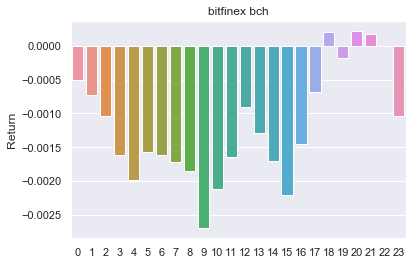

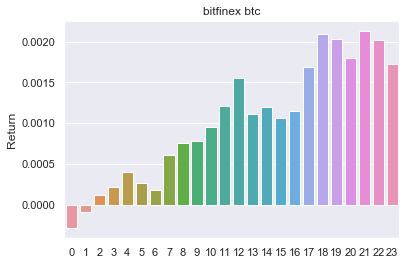

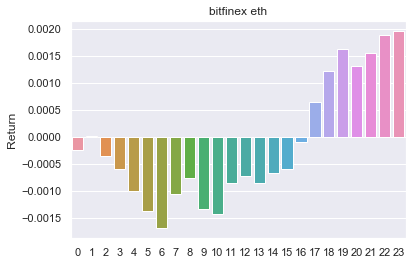

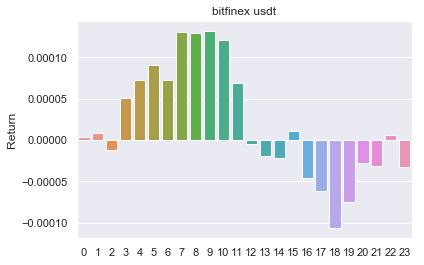

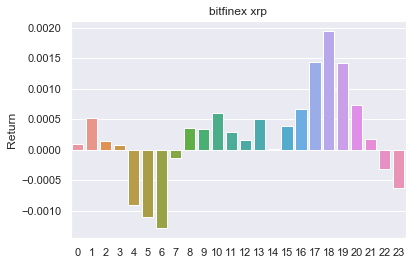

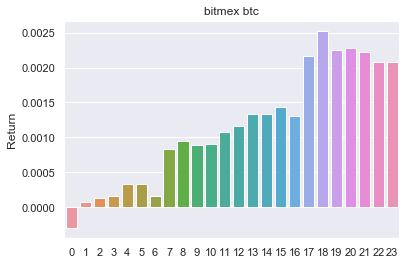

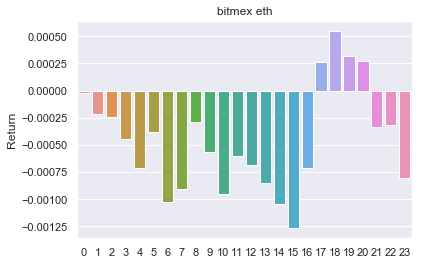

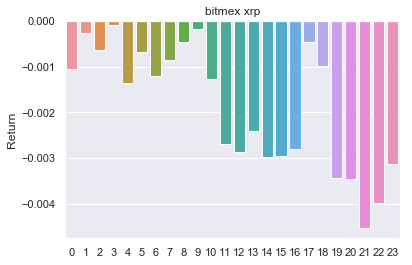

In [20]:
# plot cumulative return in an average day
for i in range(len(df_)):
    plt.clf()
    a = dfCumuRtn_[i]
    
    a.index = np.arange(24)
    a = pd.DataFrame(a)
    a.columns = ['Return']
    a.reset_index(inplace=True)
    
    ax = sns.barplot(x=a.index, y=a.Return, order=a.index, data=a)    
    ax.set_title(fns_name(fns[i]))
    plt.show()
    

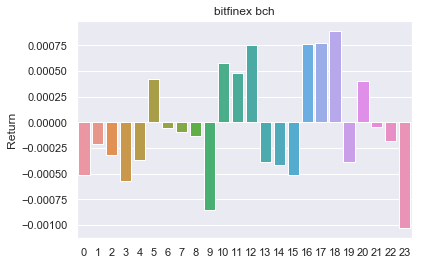

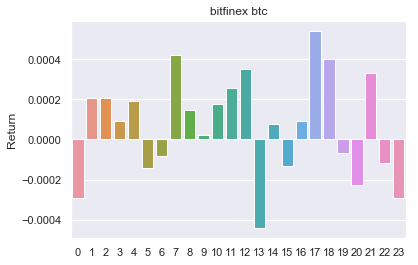

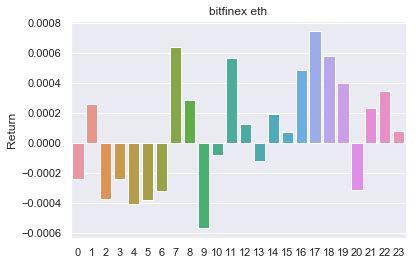

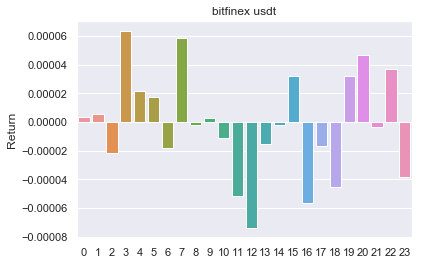

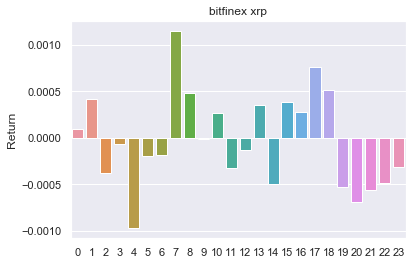

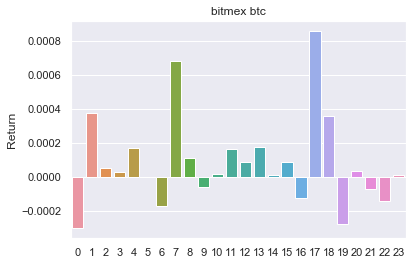

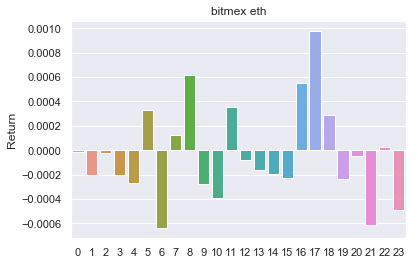

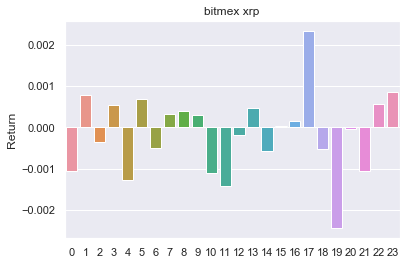

In [21]:
# plot hourly return in an average day
for i in range(len(df_)):
    plt.clf()
    a = dfRtn_[i]
    
    a.index = np.arange(24)
    a = pd.DataFrame(a)
    a.columns = ['Return']
    a.reset_index(inplace=True)
    
    ax = sns.barplot(x=a.index, y=a.Return, order=a.index, data=a)    
    ax.set_title(fns_name(fns[i]))
    plt.show()
    

In [22]:
# simple t test to test if hourly return is significantly different from zero 
for i in range(len(df_)):
    print(fns_name(fns[i]))
    a = dfReturnDay_[i]
    for j in range(a.shape[1]):
        t = a.columns[j][1]
        t_stat, p_val = stats.ttest_1samp(a.iloc[:,j], 0, nan_policy='omit')
        if p_val < 0.1:
            print(t, '   ', p_val)
    print('\n')

bitfinex bch
18:00:00     0.0644250717421108
23:00:00     0.025660817699709106


bitfinex btc
07:00:00     0.03248932616618708
13:00:00     0.03984829614122249
17:00:00     0.020479258714332618
18:00:00     0.029630129516563138


bitfinex eth
07:00:00     0.04104999371567203
09:00:00     0.07958017513326507
11:00:00     0.07509535515673006
16:00:00     0.09152629230033615
17:00:00     0.00917303795271501
18:00:00     0.06349078914756683


bitfinex usdt
03:00:00     0.03429302606989488
07:00:00     0.048922049307131316
11:00:00     0.0964565167122838
12:00:00     0.05714013207793329


bitfinex xrp
04:00:00     0.024354451410406104
07:00:00     0.007866584511007057
20:00:00     0.0990521258054416


bitmex btc
01:00:00     0.039876509399885685
07:00:00     0.002301411723830004
17:00:00     0.00019977457727133325


bitmex eth
08:00:00     0.09370777786476008
17:00:00     0.010261193825440168
21:00:00     0.09939076190409242


bitmex xrp
04:00:00     0.06264373042259207
17:00:00     0.01026

In [23]:
# find max return and time
maxRtn_ = []; maxRtnIndex_ = []
for i in range(len(df_)):
    a = dfRtn_[i]
    print(fns_name(fns[i]))
    r, ind = maxCircularSum(a)
    maxRtn_.append(r)
    maxRtnIndex_.append(ind)
    print(r, ind)

bitfinex bch
0.0029319018256043308 [10, 20]
bitfinex btc
0.002427654569313674 [1, 21]
bitfinex eth
0.003680471955361744 [7, 1]
bitfinex usdt
0.0002064296635557597 [19, 9]
bitfinex xrp
0.0032408239568357195 [7, 18]
bitmex btc
0.002827660839400698 [1, 18]
bitmex eth
0.0018191752690977468 [16, 18]
bitmex xrp
0.0025191851286049134 [15, 17]


In [24]:
# 2-sample t test: Welch’s t-test

for i in range(len(df_)):
    l, r = maxRtnIndex_[i]
    a = dfRtn_[i]
    if l < r:
        a1 = a.iloc[l:r+1]
        a2 = pd.concat([a.iloc[:l], a.iloc[r+1:]])
    elif l > r:
        a1 = pd.concat([a.iloc[l:], a.iloc[:r+1]])
        a2 = a.iloc[r+1:l]
    elif l == r:
        a1 = a.iloc[l]
        a2 = pd.concat([a.iloc[:l], a.iloc[l+1:]])

    # print(a1.describe())
    # print(a.describe())
   
    t_stat, p_val = stats.ttest_ind(a1, a2, equal_var = False, nan_policy='omit')
    if p_val > 0.1:
        print(fns_name(fns[i]))
        print(t_stat, p_val, '\n')
    

bitmex xrp
1.4361694561419354 0.2731689241267889 



only bitmex xrp result is not significant: 
- p value = 0.27

<br>the other cryptos are significantly at least at 90% level

In [25]:
# can we identify which country as well? or a combination of countries? 

#### *long short strategy*

bitfinex bch
| Stats   |    Results     |
|---------|----------------|
| Return  |     3.8921     |
| Vol     |     0.7032     |
| Sharpe  |     5.4777     |
| Skew    |     0.2325     |
| Kurt    |     7.5799     |
| VaR     | 115230343.1437 |
| MDD     |    -0.2959     |




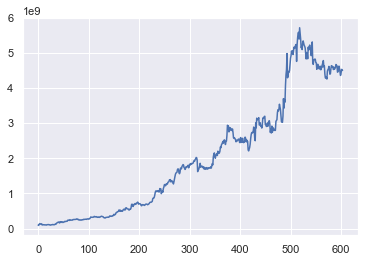

bitfinex btc
| Stats   |     Results     |
|---------|-----------------|
| Return  |     1.0494      |
| Vol     |     0.6564      |
| Sharpe  |     1.5378      |
| Skew    |     -3.9062     |
| Kurt    |     91.8744     |
| VaR     | 3964574075.6808 |
| MDD     |     -0.6682     |




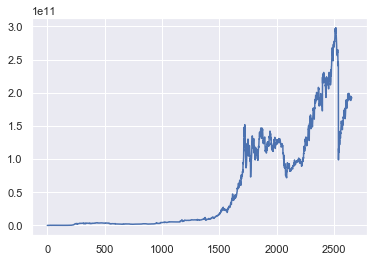

bitfinex eth
| Stats   |     Results     |
|---------|-----------------|
| Return  |     2.3390      |
| Vol     |     0.7071      |
| Sharpe  |     3.2514      |
| Skew    |     0.5228      |
| Kurt    |     4.3336      |
| VaR     | 6047004892.5541 |
| MDD     |     -0.6257     |




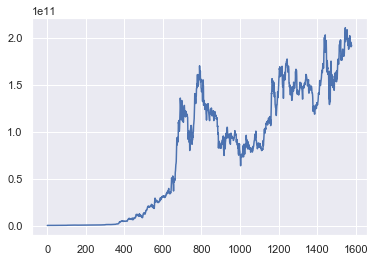

bitfinex usdt
| Stats   |   Results   |
|---------|-------------|
| Return  |   0.0955    |
| Vol     |   0.0468    |
| Sharpe  |   1.1870    |
| Skew    |   1.2211    |
| Kurt    |   11.5044   |
| VaR     | 342235.2730 |
| MDD     |   -0.0540   |




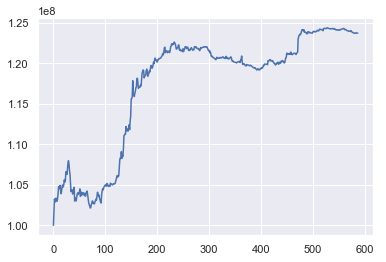

bitfinex xrp
| Stats   |     Results     |
|---------|-----------------|
| Return  |     3.9378      |
| Vol     |     0.8543      |
| Sharpe  |     4.5624      |
| Skew    |     0.1340      |
| Kurt    |     19.3521     |
| VaR     | 1631287085.4691 |
| MDD     |     -0.4301     |




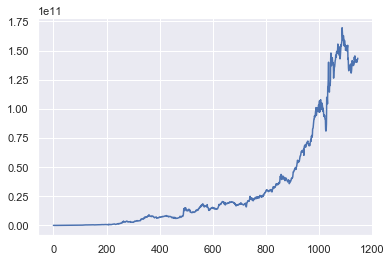

bitmex btc
| Stats   |    Results     |
|---------|----------------|
| Return  |     1.2151     |
| Vol     |     0.5250     |
| Sharpe  |     2.2384     |
| Skew    |    -0.2002     |
| Kurt    |    10.7177     |
| VaR     | 177706674.4054 |
| MDD     |    -0.4908     |




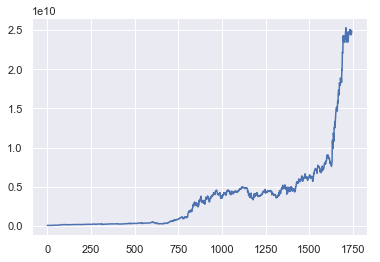

bitmex eth
| Stats   |    Results    |
|---------|---------------|
| Return  |    1.5574     |
| Vol     |    0.6622     |
| Sharpe  |    2.2914     |
| Skew    |    0.1822     |
| Kurt    |    3.2024     |
| VaR     | 34021165.6806 |
| MDD     |    -0.5085    |




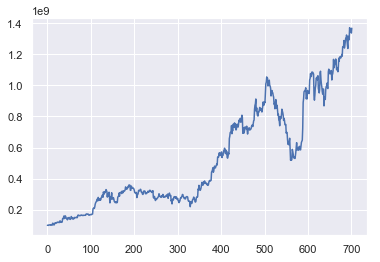

bitmex xrp
| Stats   |   Results    |
|---------|--------------|
| Return  |    4.6202    |
| Vol     |    0.6042    |
| Sharpe  |    7.5809    |
| Skew    |    1.7750    |
| Kurt    |    8.0318    |
| VaR     | 7467581.1165 |
| MDD     |   -0.2214    |




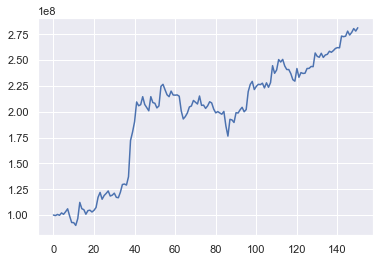

In [26]:

# transaction cost =10%+ as taker fee 
# for Crypto-to-Fiat on bitfinex 

fee = 0.1

for i in range(len(df_)):

    a = dfReturnDay_[i]
    holding = pd.DataFrame().reindex_like(a)
    holding.iloc[:,:] = -1

    l, r = maxRtnIndex_[i]


    for j in range(0, a.shape[0]):
        if l < r:
            holding.iloc[j, l:r+1] = 1
        elif l == r:
            holding.iloc[j, l] = 1
        elif l > r:
            holding.iloc[j, l:] = 1
            holding.iloc[j, :r+1] = 1

    rtns = ( np.exp(holding * a) - 1 ).sum(axis=1)   # approximate 
    rtns *= (1-fee)**2 

    nav = [1e8]
    for rt in rtns:
        nav.append(nav[-1] * (1 + rt))

    show_performance(nav)    

    plt.plot(nav)
    plt.show()

#### *regression / cart*

In [27]:
# variables: Vol, time dummies, past return, +macros(fed, equity mkt, vix, corp spread, )

In [28]:
# literature uses GARCH (egarch, ) for vol 

In [29]:
i=0

In [30]:
Ret = df_[i].copy()['Return']
# Ret = Ret[Ret!=0]

Ret.index = v_get_time(Ret.index)
Ret_resid = Ret - Ret.shift(1) * rho_[i]   

N_roll = 30
Vol = Ret.rolling(N_roll).apply(lambda x: np.sum(x**2) / len(x))

In [31]:
l, r = maxRtnIndex_[i]
time = Ret.index.map(lambda x: x.split()[-1])
dummy = pd.Series().reindex_like(Ret)
dummy[:] = 0
if l < r:
    dummy[(time >= str(l)) & (time <= str(r))] = 1
elif l > r:
    dummy[(time >= str(l)) | (time <= str(r))] = 1
elif  l==r:
    dummy[time == str(l)] = 1

c:\program files (x86)\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
y = Ret

In [33]:
X1 = y.shift(1)   # r_{t-1}
X2 = Vol.shift(1)           # vol_{t-1}
X3 = dummy               # time dummy: =1 if in maxRtnTime else 0 
X = pd.concat([X1, X2, X3], axis=1)
X.columns = ['R_t-1', 'Vol_t-1', 't_dummy']

X = X.iloc[N_roll+1:]
y = y.iloc[N_roll+1:]

In [34]:
# split train and validation
n_split = np.int(X.shape[0]*0.8) +1
X_train, X_test = X.iloc[:n_split], X.iloc[n_split:]   
y_train, y_test = y.iloc[:n_split], y.iloc[n_split:]

In [35]:
# train cart 

clf = tree.DecisionTreeRegressor()
clf.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [36]:
import joblib
# filename = 'cart '+fns_name(fns[i])+'.sav'
# joblib.dump(clf, filename)

# clf = joblib.load('cart bitmex xrp.sav')

In [37]:
features = ['R_t-1', 'Vol_t-1', 't_dummy']
# class_names = []
# tree.export_graphviz(clf,
#                      out_file="tree.dot",
#                      feature_names = features, 
#                      class_names=None,
#                      filled = True)

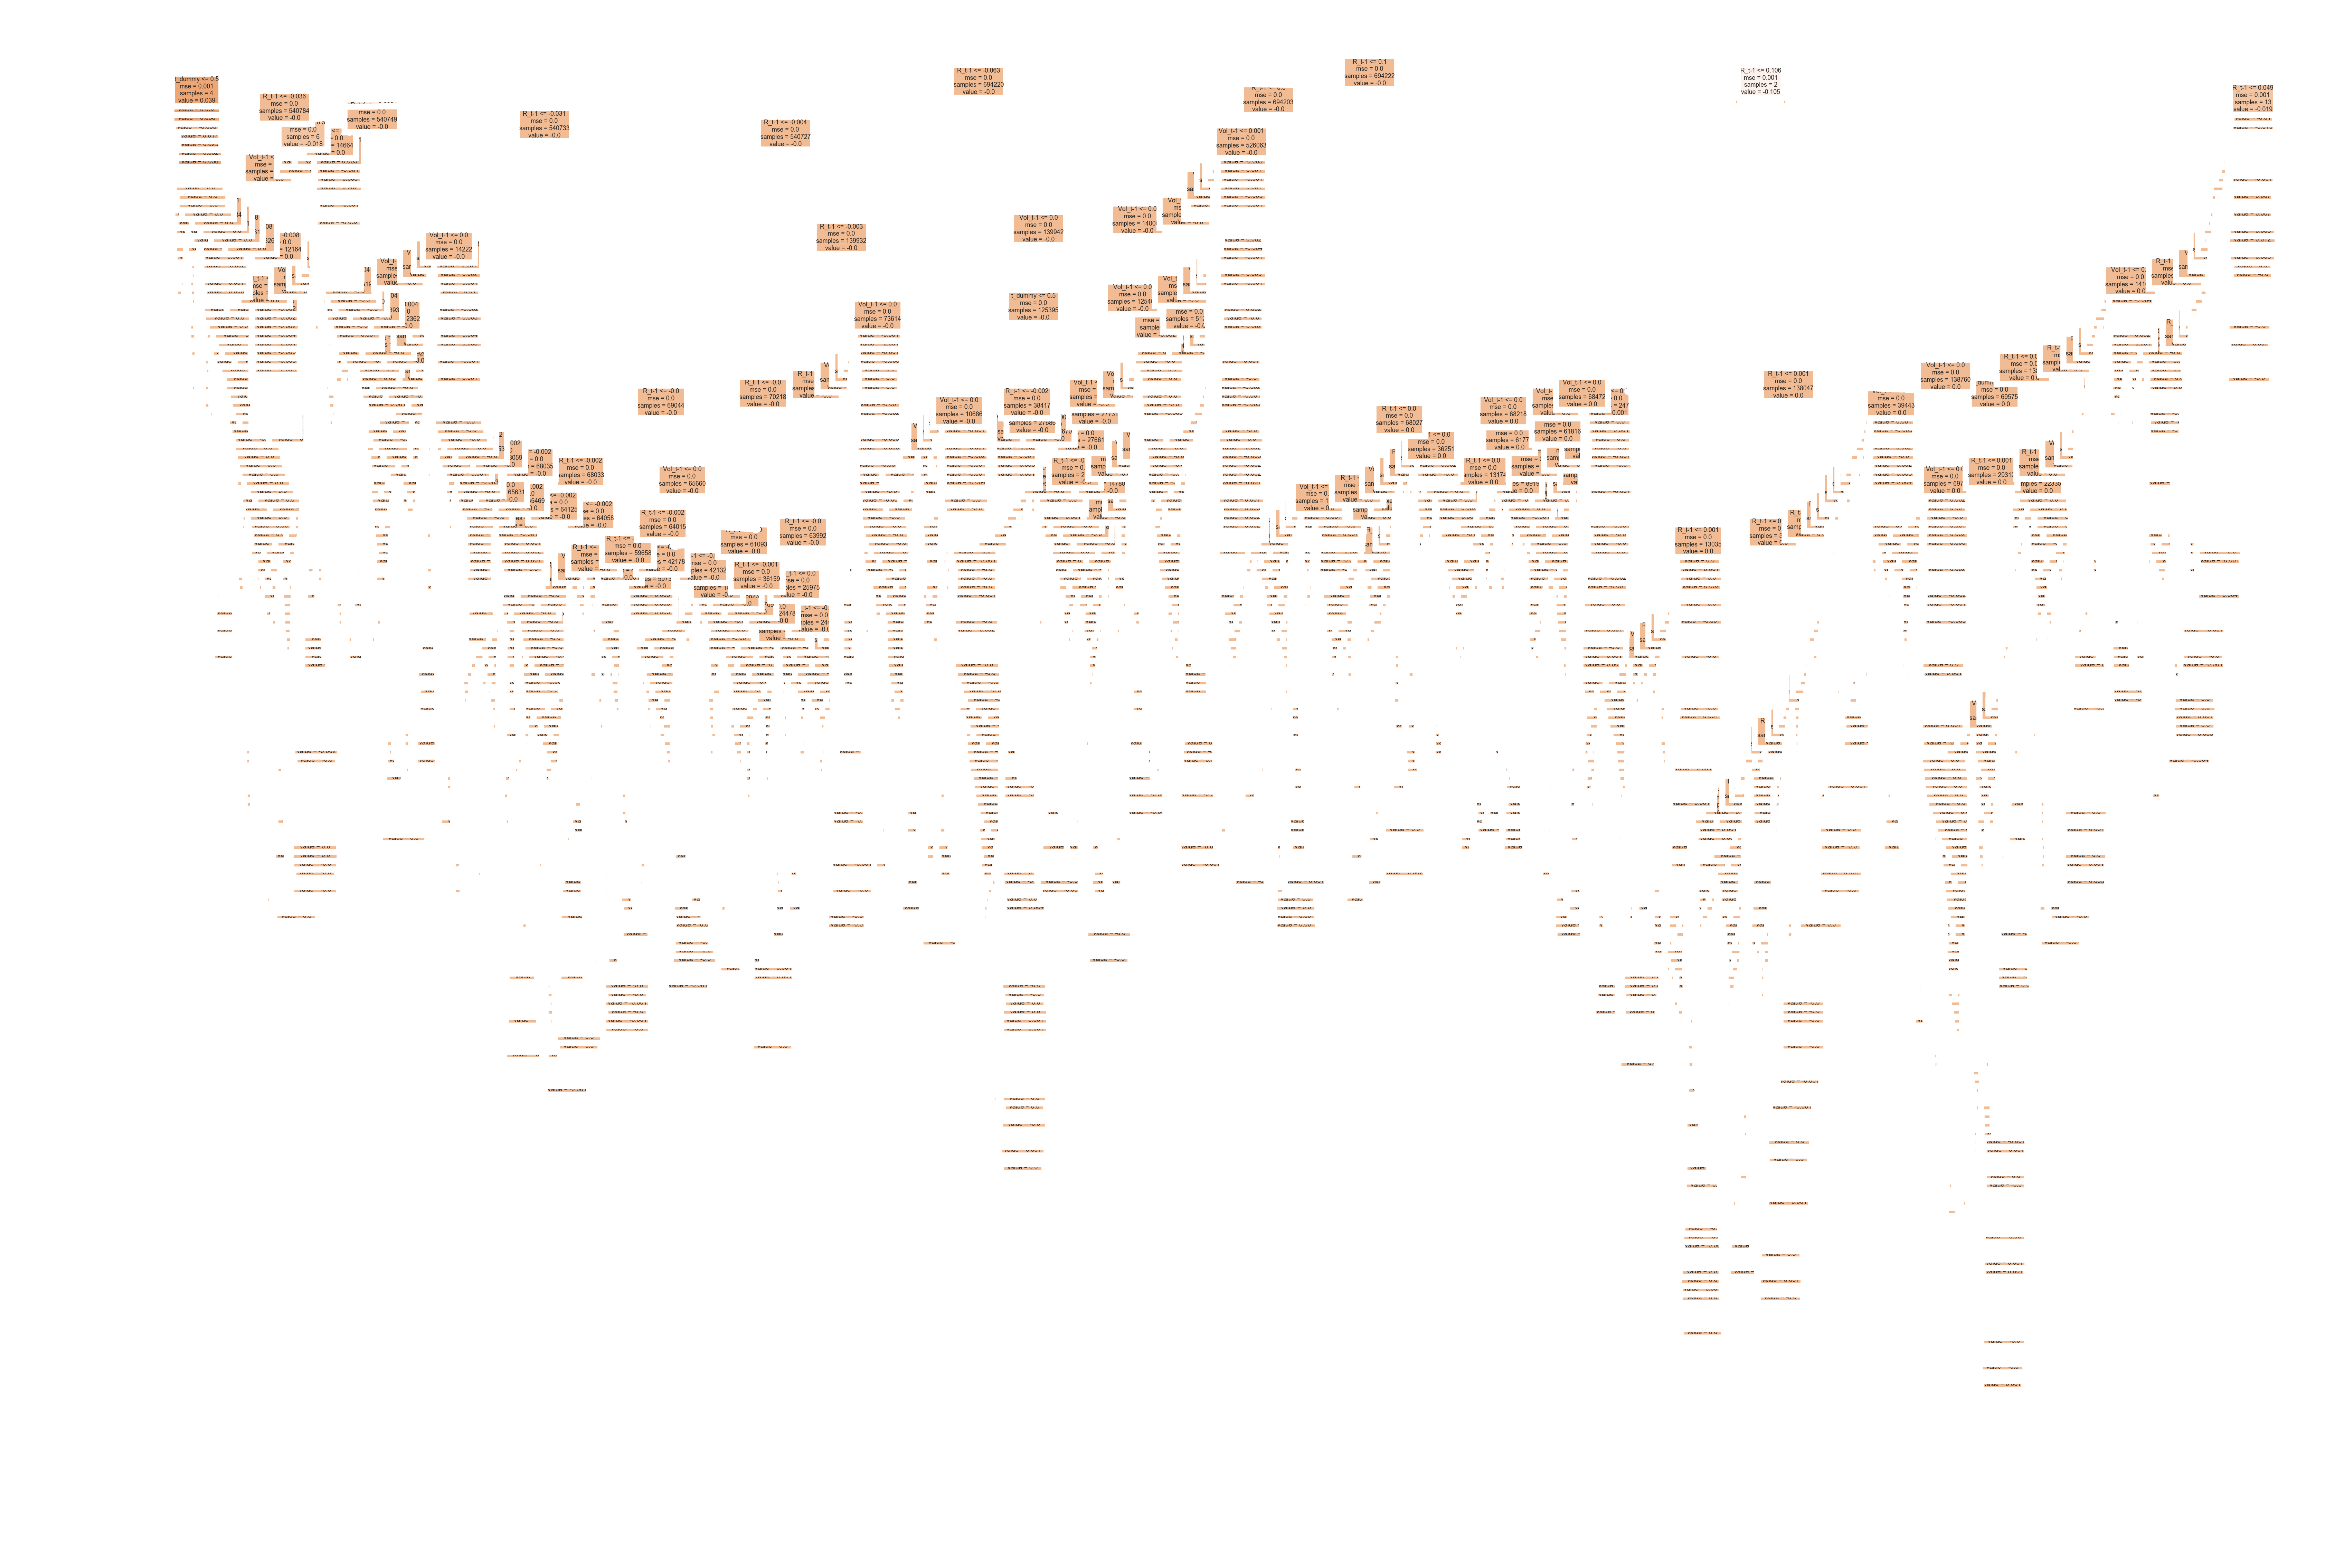

In [38]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, dpi=1280)
tree.plot_tree(clf,
               feature_names = features, 
               class_names=None,
               filled = True);
fig.savefig('tree.png')

In [39]:
# predict
y_pred = clf.predict(X_test)

mse = np.sum((y_pred - y_test)**2) / len(y_test)
mae = np.sum(np.abs(y_pred - y_test)) / len(y_test)
print('mse: ', mse)
print('mae: ', mae)

mse:  5.130918012989948e-06
mae:  0.0008644621556034623


<Figure size 432x288 with 0 Axes>

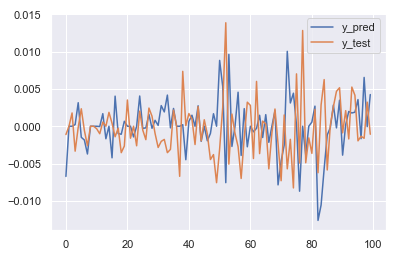

In [40]:
plt.clf()
Y = pd.DataFrame(columns = ['y_pred', 'y_test'])
Y['y_pred'] = y_pred
Y['y_test'] = y_test.values
Y.iloc[:100].plot()

In [41]:
# post pruning to avoid overfitting 
# - Cost complexity Pruning

In [42]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

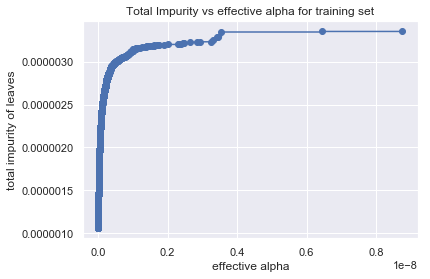

In [43]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

#### *others*

In [ ]:
# exclude weekend and holiday 
# days with no trades 
# day light saving times
# long short strategy (some paper uses bid and ask)
# stability of effect over time 


#### *Volatility Pattern*

In [ ]:
freq = '1h'
g = agg_Max

In [ ]:
 
DF_max = []; DF_min = []
Rtn_max = []; Rtn_min = []

for i in range(len(df_)):   
    df_resid = df_[i].copy()
    df_resid['Return'] -= df_resid['Return'] * rho_[i]   # residual 
    
    res = get_extreme_vol(agg_data(df_resid, freq = freq),f=g)
    DF_max.append(res[0])
    Rtn_max.append(res[1])
    DF_min.append(res[2])
    Rtn_min.append(res[3])
    
DF_ = DF_max; Rtn_ = Rtn_max; flag = '(high)'

fig, axs = plt.subplots(8,2, figsize=(11, 35))
plt.subplots_adjust(hspace=0.5, wspace=0.4)

for i in range(len(axs)):
#     for j in range(len(axs[0])):
        ax = axs[i]
        sns.heatmap(DF_[i], cmap="Blues", cbar=False, ax=ax[0])
        Rtn_[i].plot(ax=ax[1])
        ax[0].set_title(fns_name(fns[i])+'   highest period')
        ax[1].set_title('vol '+flag)

In [ ]:
DF_ = DF_min; Rtn_ = Rtn_min; flag = '(low)'

fig, axs = plt.subplots(8,2, figsize=(11, 35))
plt.subplots_adjust(hspace=0.5, wspace=0.4)
f = lambda x: ' '.join(x.split('_')[:-1])
for i in range(len(axs)):
        ax = axs[i]
        sns.heatmap(DF_[i], cmap="Blues", cbar=False, ax=ax[0])
        Rtn_[i].plot(ax=ax[1])
        ax[0].set_title(fns_name(fns[i])+'   lowest period')
        ax[1].set_title('vol '+flag)

#### *Return Pattern*

In [ ]:
freq = '4h'
g = agg_Max

In [ ]:
# 
DF_max = []; DF_min = []
Rtn_max = []; Rtn_min = []

for i in range(len(df_)):   
    res = get_extreme_return(agg_data(df_[i], freq = freq),f=g)
    DF_max.append(res[0])
    Rtn_max.append(res[1])
    DF_min.append(res[2])
    Rtn_min.append(res[3])
    
DF_ = DF_max; Rtn_ = Rtn_max; flag = '(high)'

fig, axs = plt.subplots(8,2, figsize=(11, 35))
plt.subplots_adjust(hspace=0.5, wspace=0.4)
f = lambda x: ' '.join(x.split('_')[:-1])
for i in range(len(axs)):
#     for j in range(len(axs[0])):
        ax = axs[i]
        sns.heatmap(DF_[i], cmap="Blues", cbar=False, ax=ax[0])
        Rtn_[i].plot(ax=ax[1])
        ax[0].set_title(fns_name(fns[i])+'   highest period')
        ax[1].set_title('return '+flag)

In [ ]:
DF_ = DF_min; Rtn_ = Rtn_min; flag = '(low)'

fig, axs = plt.subplots(8,2, figsize=(11, 35))
plt.subplots_adjust(hspace=0.5, wspace=0.4)
f = lambda x: ' '.join(x.split('_')[:-1])
for i in range(len(axs)):
        ax = axs[i]
        sns.heatmap(DF_[i], cmap="Blues", cbar=False, ax=ax[0])
        Rtn_[i].plot(ax=ax[1])
        ax[0].set_title(fns_name(fns[i])+'   lowest period')
        ax[1].set_title('return '+flag)